In our case, the dataset will be a subset of an airline's customer database.  The data contains information from the customer file, combined with information from the records of flights that each customer has taken.  

Identifiers Contained in the Data

The original data set contains each customer's frequent flier account number, as well as name, date of birth, passport number (if known by the airline) and home address.  The fields for any direct identifiers will be not be extracted from the database, but the customer's calculated age, home zip code, and gender will be extracted from the database.

For each flight, the flight number, origin and destination codes, mileage, date and departure time will be included for each passenger in the subset.

The airline has also declared that the records of any minors be excluded from the data extraction to protect the most sensitive passengers.  

The stated objective of the release of data is for review of the data for improvements in the times and routes covered, but leaving open the possibility of additional findings by trying to show the data as deep as possible.

In [25]:
# import packages

import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
import sklearn as sk
import statsmodels.api as sm
#import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pandas.tools.plotting import scatter_plot
from pandas.tools.plotting import scatter_matrix

from sklearn.preprocessing import scale, StandardScaler
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression, Lasso, Lars, SGDRegressor

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
from Crypto.Cipher import AES

import random


#import locale
#locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

from pandas.tools.plotting import scatter_matrix

from sklearn.svm import SVR
from sklearn.feature_selection import RFE, RFECV

from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

#configure the random seed so we our randomness is reproducible for selection of learn/test sets
np.random.seed(0)

%matplotlib inline

In [15]:
#Data gathering 

In [16]:
#Use the flight data from our other project
OnTime = pd.read_csv("Data/20170112_DataMiningI_TestDataSet_EXP_DS.csv")
OnTime = OnTime.loc[OnTime['flight_type_code']!= 'X']
OnTime['route_sequence_number'] = OnTime['route_sequence_number']/100000000
#Create indicator for ontime performance, where 1 = OnTime and 0 = LATE
OnTime['OnTimeIndicator'] = np.where(OnTime['dot_delay_mins']>=15, 0, 1)
#Need some Time of Day buckets
OnTime['TimeBucket']=pd.cut(OnTime['local_scheduled_dep_time'],[0, 600, 700, 1200, 2000, 2200,2800],6, 
       labels=["deep_shoulder_am", "shoulder_am", "am_meat", "pm_meat", "shoulder_pm","deep_shoulder_pm"])
#Need an "International" code
OnTime['International'] = np.where(OnTime['origin_country']!=OnTime['destination_country'], 1, 0)
del OnTime['flt_attendant_change_ind']
OnTime['Originator_ind'] = np.where(OnTime['route_sequence_number']== 1.0,1,0)
OnTime['D_zero_ind'] = np.where(OnTime['push_delay_mins']== 0,1,0)


OnTime = OnTime.ix[:,['origin', 'destination', 'departure_date', 'flight_route_number']]

In [17]:
OnTime.columns

Index(['origin', 'destination', 'departure_date', 'flight_route_number'], dtype='object')

In [18]:
#Get a list of Zip Codes
ZipCode = pd.read_csv("free-zipcode-database-Primary.csv")
ZipCode.head()
ZipCode = ZipCode.sample(500)

In [19]:
#Build a dataset

ncustomer = 10000

#Customers 1->n
Customer = pd.DataFrame(list(range(0,ncustomer)), columns=["CustomerNumber"])

#Make half male
Gender = np.random.randint(0,2, size=(ncustomer,1))
Customer['Gender'] = Gender

#Create ages distributed normally from 18 to max of 90 with a mean of 37.8, maybe a 15 year standard deviation
Age = 4.8* np.random.randn(ncustomer,1) + 44
Customer['Age'] = Age


#print(Age)
#print(Age.min(), Age.max())
#sns.distplot(Age)


#Get a random sample of zipcodes

MyZip = np.array(ZipCode['Zipcode'].sample(ncustomer, replace = True))
MyZip.shape = (ncustomer,1)
Customer['ZipCode'] = MyZip

#randomly create a number of flights for a customer from 1-250 flights
TotalFlights=7 * np.random.randn(ncustomer, 1) + 4

#Convert to integer for flight numbers (round)
#Force negatives to 0
TotalFlights[TotalFlights<0] = 0
TotalFlights = TotalFlights.round().astype(int)
TotalFlights[TotalFlights>30] = 0
TotalFlights.shape = (ncustomer,1)
Customer['TotalFlights']=TotalFlights

Customer.head()
Customer.shape




(10000, 5)

In [20]:
CustFlight = []

#Loop through customers
for cust in Customer['CustomerNumber']:
    myflights = Customer['TotalFlights'][cust]

    if myflights > 0:
        #for each customer, select n random flights from the OnTime document
        thiscustomerflights = OnTime.sample(n=myflights)
        thiscustomerflights['customer'] = cust
        CustFlight.append(thiscustomerflights)
        #print(thiscustomerflights)


    
    #put into CustFlight

CustFlight = pd.concat(CustFlight, axis=0)
print(CustFlight)


       origin destination departure_date  flight_route_number  customer
28688     BUR         LAS      5/31/2016                  172         1
110690    SMF         ONT      5/30/2016                  333         1
71297     TPA         HOU      5/24/2016                  594         1
22657     MDW         BNA      5/22/2016                  278         1
92966     SAN         MCI      5/26/2016                  486         1
32823     MSP         MDW      5/19/2016                  218         1
101272    BNA         SAN      5/29/2016                  222         1
2754      PHX         GEG       5/1/2016                   80         1
24762     MDW         RDU      5/22/2016                  238         1
8308      STL         AUS      5/17/2016                  287         1
19707     STL         HOU       5/3/2016                  286         1
73750     STL         PHL      5/29/2016                  308         1
24917     MCO         PIT      5/17/2016                  217   

5.2019000000000002

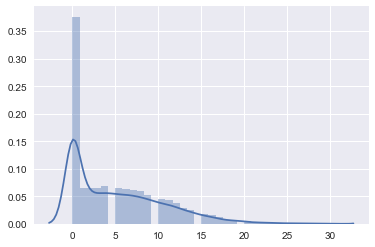

In [21]:
sns.distplot(TotalFlights)
TotalFlights.mean()

Quasi-Identifiers within this dataset include the intersection of Zip/Age/Gender.  Should we also include home airport as a quasi-idenitifer? This isn't necessarily a directly designated airport but it's the most frequent airport a flier goes to.

   Code
0   ABQ
1   ALB
2   AMA
3   ATL
4   AUA
5   AUS
6   BDL
7   BHM
8   BNA
9   BOI
10  BOS
11  BUF
12  BUR
13  BWI
14  BZE
15  CAK
16  CHS
17  CLE
18  CLT
19  CMH
20  CRP
21  CUN
22  DAL
23  DAY
24  DCA
25  DEN
26  DSM
27  DTW
28  ECP
29  ELP
..  ...
67  PDX
68  PHL
69  PHX
70  PIT
71  PNS
72  PUJ
73  PVD
74  PVR
75  PWM
76  RDU
77  RIC
78  RNO
79  ROC
80  RSW
81  SAN
82  SAT
83  SDF
84  SEA
85  SFO
86  SJC
87  SJD
88  SJO
89  SJU
90  SLC
91  SMF
92  SNA
93  STL
94  TPA
95  TUL
96  TUS

[97 rows x 1 columns]


In [113]:
#Does strong encryption of categorical variables allow for 
#a data digger to still backwards derive the flyer's identity?

from Crypto import Random
import base64

#Make a unique list of airport codes 

AirportCode = pd.DataFrame(np.unique(CustFlight['origin']), columns=['Code'])
print(AirportCode)

mykey = 'SMUMarchMadNeSsS'
mykey = mykey.encode('UTF-8')

#pad to a multiple of 16 using the mod function
teststring = 'ATL'
#teststring = bytes(teststring, ) + bytes(' '*(len(mykey)-len(teststring)%len(mykey)), 'UTF-8')

#make an initialization vector for the encryption
iv = Random.new().read(AES.block_size)

cipher = AES.new(mykey, AES.MODE_CBC, IV=iv)

#temp = cipher.encrypt(teststring)

teststring = bytes(teststring, 'UTF-8')
teststring = teststring + bytes(' '*(len(mykey)-len(teststring)%len(mykey)), 'UTF-8')

encoded = 



#AirportCode['Enc'] = AirportCode.apply(print(AirportCode['Code']), axis = 0)


   Code
0   ABQ
1   ALB
2   AMA
3   ATL
4   AUA
5   AUS
6   BDL
7   BHM
8   BNA
9   BOI
10  BOS
11  BUF
12  BUR
13  BWI
14  BZE
15  CAK
16  CHS
17  CLE
18  CLT
19  CMH
20  CRP
21  CUN
22  DAL
23  DAY
24  DCA
25  DEN
26  DSM
27  DTW
28  ECP
29  ELP
..  ...
67  PDX
68  PHL
69  PHX
70  PIT
71  PNS
72  PUJ
73  PVD
74  PVR
75  PWM
76  RDU
77  RIC
78  RNO
79  ROC
80  RSW
81  SAN
82  SAT
83  SDF
84  SEA
85  SFO
86  SJC
87  SJD
88  SJO
89  SJU
90  SLC
91  SMF
92  SNA
93  STL
94  TPA
95  TUL
96  TUS

[97 rows x 1 columns]


In [16]:
# alex messing with code


In [112]:
# read in names

male_first_names = pd.read_csv('Data/census-dist-male-first.csv')

female_first_names = pd.read_csv('Data/census-dist-female-first.csv')

last_names = pd.read_csv('Data/dist.all.last.csv')

print(male_first_names.head(), female_first_names.head(), last_names.head())




FileNotFoundError: File b'Data/census-dist-male-first.csv' does not exist

In [111]:
# create names -THIS DOESNT WORK...NOT SURE WHY

for person in Customer['CustomerNumber']:
    if (Customer['Gender']==1).bool == True:
        Customer['first_name'] = male_first_names['name'].sample(n= 1)
    else:
        Customer['first_name'] = female_first_names['name'].sample(n=1)
        



NameError: name 'female_first_names' is not defined

In [95]:
for person in Customer['CustomerNumber']:
        Customer['first_name'] = male_first_names['name'].sample(n= 1)
   

In [ ]:
#With or Without encryption can we demonstrate l-diversity, k-anononymous, and t-closeness of the slices?
#Or demonstrate what the odds of reidentification are for a flyer?

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: first_name, dtype: object

In [ ]:
#How can we avoid reidentification of a flyer based on background knowledge?